In [1]:
# Installiamo la libreria yfinance per scaricare i dati storici da Yahoo Finance
!pip install yfinance

# Importiamo le librerie necessarie per il nostro progetto
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Impostiamo uno stile grafico piacevole per i nostri plot
sns.set_style('whitegrid')

In [2]:
# Definiamo il ticker del nostro asset e l'intervallo di date
ticker = 'SPY'
start_date = '2010-01-01'
end_date = '2024-12-31' # Usiamo una data futura per assicurarci di avere i dati più recenti

# Scarichiamo i dati utilizzando yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Visualizziamo le prime 5 righe del DataFrame per assicurarci che sia tutto corretto
print(data.head())

# Visualizziamo le ultime 5 righe
print(data.tail())

/tmp/ipython-input-2-2303404774.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker            SPY        SPY        SPY        SPY        SPY
Date                                                             
2010-01-04  85.515648  85.560920  84.142327  84.791259  118944600
2010-01-05  85.742020  85.779751  85.153454  85.462832  111579900
2010-01-06  85.802383  86.013663  85.591104  85.659013  116074400
2010-01-07  86.164581  86.270221  85.402462  85.643925  131091100
2010-01-08  86.451302  86.489032  85.764644  85.938192  126402800
Price            Close        High         Low        Open    Volume
Ticker             SPY         SPY         SPY         SPY       SPY
Date                                                                
2024-12-23  591.158813  591.765177  584.170528  587.381389  57635800
2024-12-24  597.729553  597.769355  591.934154  592.520677  33160100
2024-12-26  597.769348  598.902533  594.528696  595.940247  41219100
2024-12-27  591.476868  594.230439  587.252104  593.991813

In [3]:
# Definiamo i periodi per le nostre medie mobili
short_window = 50
long_window = 200

# Calcoliamo le medie mobili semplici (SMA) e le aggiungiamo come nuove colonne al nostro DataFrame
data['SMA_short'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['SMA_long'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Creiamo il segnale di trading
# np.where(condizione, valore_se_vero, valore_se_falso)
# 1 significa "Long" (compra/tieni), 0 significa "Flat" (vendi/non avere posizioni)
data['Signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1.0, 0.0)

# Per evitare di fare trading ogni giorno, generiamo il segnale solo nel giorno del crossover.
# 'Position' rappresenta l'azione da compiere: 1 per comprare, -1 per vendere.
data['Position'] = data['Signal'].diff()

# Visualizziamo il dataframe con le nuove colonne
print(data.tail(10))

Price            Close        High         Low        Open     Volume  \
Ticker             SPY         SPY         SPY         SPY        SPY   
Date                                                                    
2024-12-16  601.163574  602.144445  599.598268  600.380921   43695200   
2024-12-17  598.686829  599.558674  597.299846  598.587780   55773500   
2024-12-18  580.843872  600.787165  580.457474  598.379704  108248700   
2024-12-19  580.665405  587.501450  580.417723  585.876642   85919500   
2024-12-20  587.639832  592.212493  577.460585  578.315524  125716700   
2024-12-23  591.158813  591.765177  584.170528  587.381389   57635800   
2024-12-24  597.729553  597.769355  591.934154  592.520677   33160100   
2024-12-26  597.769348  598.902533  594.528696  595.940247   41219100   
2024-12-27  591.476868  594.230439  587.252104  593.991813   64969300   
2024-12-30  584.727173  588.226291  580.939799  584.399176   56578800   

Price        SMA_short    SMA_long Signal Position

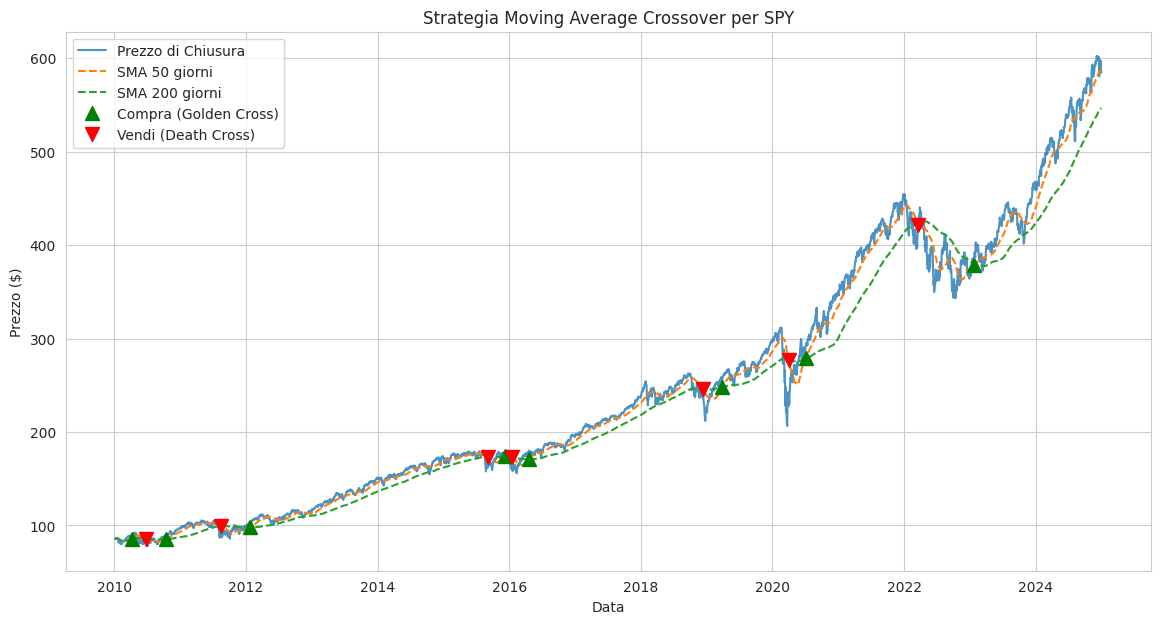

In [9]:
# Creiamo un grafico per visualizzare i prezzi e le medie mobili
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Prezzo di Chiusura', alpha=0.8)
plt.plot(data['SMA_short'], label=f'SMA {short_window} giorni', linestyle='--')
plt.plot(data['SMA_long'], label=f'SMA {long_window} giorni', linestyle='--')

# Aggiungiamo i segnali di acquisto (triangolo verde verso l'alto)
plt.plot(data[data['Position'] == 1].index,
         data['SMA_short'][data['Position'] == 1],
         '^', markersize=10, color='g', label='Compra (Golden Cross)')

# Aggiungiamo i segnali di vendita (triangolo rosso verso il basso)
plt.plot(data[data['Position'] == -1].index,
         data['SMA_short'][data['Position'] == -1],
         'v', markersize=10, color='r', label='Vendi (Death Cross)')

plt.title(f'Strategia Moving Average Crossover per {ticker}')
plt.xlabel('Data')
plt.ylabel('Prezzo ($)')
plt.legend()
plt.show()

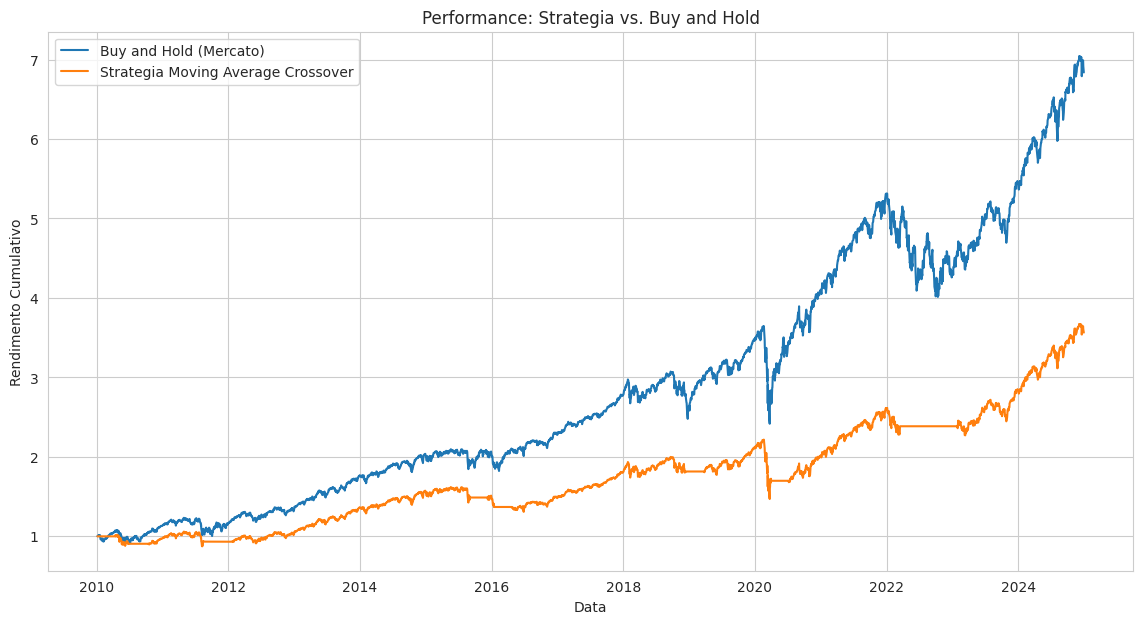

In [10]:
# Calcoliamo il rendimento giornaliero dell'asset (Buy and Hold)
data['Market_Returns'] = data['Close'].pct_change()

# Calcoliamo il rendimento giornaliero della nostra strategia
# La posizione viene mantenuta dal giorno DOPO il segnale, quindi usiamo .shift(1)
data['Strategy_Returns'] = data['Market_Returns'] * data['Signal'].shift(1)

# Calcoliamo i rendimenti cumulativi per entrambe le strategie
data['Cumulative_Market_Returns'] = (1 + data['Market_Returns']).cumprod()
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()

# Visualizziamo la curva dei rendimenti (Equity Curve)
plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative_Market_Returns'], label='Buy and Hold (Mercato)')
plt.plot(data['Cumulative_Strategy_Returns'], label='Strategia Moving Average Crossover')
plt.title('Performance: Strategia vs. Buy and Hold')
plt.xlabel('Data')
plt.ylabel('Rendimento Cumulativo')
plt.legend()
plt.show()

In [11]:
# --- CALCOLO METRICHE DI PERFORMANCE ---

# 1. Rendimento Totale
total_return_strategy = data['Cumulative_Strategy_Returns'].iloc[-1] - 1
total_return_market = data['Cumulative_Market_Returns'].iloc[-1] - 1

# 2. Volatilità Annualizzata (deviazione standard dei rendimenti)
# Ci sono circa 252 giorni di trading in un anno
volatility_strategy = data['Strategy_Returns'].std() * np.sqrt(252)
volatility_market = data['Market_Returns'].std() * np.sqrt(252)

# 3. Sharpe Ratio (Rendimento aggiustato per il rischio)
# Assumiamo un tasso risk-free dello 0% per semplicità
risk_free_rate = 0
sharpe_ratio_strategy = (data['Strategy_Returns'].mean() * 252 - risk_free_rate) / volatility_strategy

# 4. Max Drawdown (Massima perdita da un picco)
def calculate_max_drawdown(cumulative_returns):
    # 1. Calcola il massimo cumulativo raggiunto fino a ogni punto nel tempo
    running_max = cumulative_returns.cummax()
    # 2. Calcola il drawdown come la differenza percentuale dal massimo cumulativo
    drawdown = (cumulative_returns - running_max) / running_max
    # 3. Il max drawdown è il minimo di questa serie (la perdita più grande)
    max_drawdown = drawdown.min()
    return max_drawdown

max_drawdown_strategy = calculate_max_drawdown(data['Cumulative_Strategy_Returns'])
max_drawdown_market = calculate_max_drawdown(data['Cumulative_Market_Returns'])


# --- STAMPA DEI RISULTATI ---
print("--- Risultati del Backtesting ---")
print(f"Periodo Analizzato: {start_date} - {data.index[-1].strftime('%Y-%m-%d')}")
print("\n--- PERFORMANCE STRATEGIA ---")
print(f"Rendimento Totale Strategia: {total_return_strategy:.2%}")
print(f"Volatilità Annualizzata Strategia: {volatility_strategy:.2%}")
print(f"Sharpe Ratio Strategia: {sharpe_ratio_strategy:.2f}")
print(f"Max Drawdown Strategia: {max_drawdown_strategy:.2%}")

print("\n--- PERFORMANCE MERCATO (BUY & HOLD) ---")
print(f"Rendimento Totale Mercato: {total_return_market:.2%}")
print(f"Volatilità Annualizzata Mercato: {volatility_market:.2%}")
print(f"Max Drawdown Mercato: {max_drawdown_market:.2%}")

--- Risultati del Backtesting ---
Periodo Analizzato: 2010-01-01 - 2024-12-30

--- PERFORMANCE STRATEGIA ---
Rendimento Totale Strategia: 256.43%
Volatilità Annualizzata Strategia: 14.01%
Sharpe Ratio Strategia: 0.68
Max Drawdown Strategia: -33.72%

--- PERFORMANCE MERCATO (BUY & HOLD) ---
Rendimento Totale Mercato: 583.77%
Volatilità Annualizzata Mercato: 17.05%
Max Drawdown Mercato: -33.72%
